In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


PATH = "biolog_data.txt"
all_data = pd.read_csv(PATH, comment="<", encoding='cp1252', delimiter="\t")
# all_data_norm = (all_data - all_data.mean()) - all_data.std()
all_data

,Experiment Description,Data Definition,Well Substrate,Data Value,Data Submitter
0,b3066 mutant Biolog assay,OD600 growth,(-)Shikimic Acid,1.74,Blattner Laboratory
1,b3072 mutant Biolog assay,OD600 growth,(-)Shikimic Acid,0.89,Blattner Laboratory
2,b3076 mutant Biolog assay,OD600 growth,(-)Shikimic Acid,1.07,Blattner Laboratory
3,b3091 mutant Biolog assay,OD600 growth,(-)Shikimic Acid,0.78,Blattner Laboratory
4,b3093 mutant Biolog assay,OD600 growth,(-)Shikimic Acid,1.43,Blattner Laboratory
...,...,...,...,...,...
100907,b4129 mutant Biolog assay,OD600 growth,Xylitol,0.19,Blattner Laboratory
100908,b4138 mutant Biolog assay,OD600 growth,Xylitol,0.22,Blattner Laboratory
100909,b4173 mutant Biolog assay,OD600 growth,Xylitol,0.15,Blattner Laboratory
100910,b4174 mutant Biolog assay,OD600 growth,Xylitol,0.15,Blattner Laboratory


In [2]:
print("Unique mutants number: ", len(set(all_data['Experiment Description'])))
print("Unique substrates number: ", len(set(all_data['Well Substrate'])))

Unique mutants number:  212
Unique substrates number:  390


In [36]:
replicated_experiments = []
forbidden_mutants = []

unique_mutants = set(all_data['Experiment Description'])
for mutant in unique_mutants:
    mutant_data = all_data[all_data["Experiment Description"] == mutant]
    mutant_unique_conditions = set(mutant_data["Well Substrate"])
    for mutant_unique_cond in mutant_unique_conditions:
        mutant_unique_cond_data = mutant_data[mutant_data["Well Substrate"] == mutant_unique_cond]
        if len(mutant_unique_cond_data) > 1:
            replicated_experiments.append(mutant_unique_cond_data)
            forbidden_mutants.append(mutant.split(" ")[0])

In [40]:
len(set(forbidden_mutants))

211

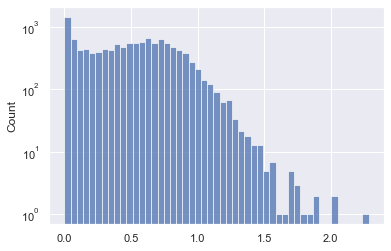

In [50]:
all_stds = []
for replicated_exp in replicated_experiments:
    all_stds.append(replicated_exp["Data Value"].std())
plt.close('all')
sns.set_theme()
sns.histplot(all_stds)
plt.yscale('log')

In [51]:
for replicated_exp in replicated_experiments:
    std = replicated_exp["Data Value"].std()
    if std > 1.5:
        print(replicated_exp)
    """if std > 1.00:
        print(replicated_exp)"""


          Experiment Description Data Definition Well Substrate  Data Value  \
97082  b4096 mutant Biolog assay    OD600 growth       Tween 80        3.08   
97288  b4096 mutant Biolog assay    OD600 growth       Tween 80        0.20   

            Data Submitter  
97082  Blattner Laboratory  
97288  Blattner Laboratory  
         Experiment Description Data Definition Well Substrate  Data Value  \
8650  b4005 mutant Biolog assay    OD600 growth        Adenine        2.79   
8862  b4005 mutant Biolog assay    OD600 growth        Adenine        0.29   

           Data Submitter  
8650  Blattner Laboratory  
8862  Blattner Laboratory  
          Experiment Description Data Definition   Well Substrate  Data Value  \
65351  b3423 mutant Biolog assay    OD600 growth  L-Phenylalanine        3.27   
65563  b3423 mutant Biolog assay    OD600 growth  L-Phenylalanine        0.17   
65775  b3423 mutant Biolog assay    OD600 growth  L-Phenylalanine        0.16   

            Data Submitter  
65

In [49]:
replicated_experiments[0]

,Experiment Description,Data Definition,Well Substrate,Data Value,Data Submitter
94181,b3416 mutant Biolog assay,OD600 growth,Thymine,1.47,Blattner Laboratory
94393,b3416 mutant Biolog assay,OD600 growth,Thymine,0.17,Blattner Laboratory


In [35]:
xp_descriptions = all_data['Experiment Description']
unique_genes = list(set([xp_desc.split(' ')[0] for xp_desc in xp_descriptions]))

In [25]:
TF_to_gene = pd.read_csv("NetWorkTFGene.txt", delimiter="\t", comment="#")
TF_to_gene

,1)regulatorId,2)regulatorName,3)RegulatorGeneName,4)regulatedId,5)regulatedName,6)function,7)confidenceLevel
0,ECK120011186,Fis,fis,ECK120000028,adhE,+,Strong
1,ECK120011186,Fis,fis,ECK120000040,osmE,-,Strong
2,ECK120011186,Fis,fis,ECK120000042,ansB,-,Weak
3,ECK120011186,Fis,fis,ECK120000043,apaG,+,Weak
4,ECK120011186,Fis,fis,ECK120000044,apaH,+,Weak
...,...,...,...,...,...,...,...
6055,ECK125336166,RpoN,rpoN,ECK120000323,mutM,-,Strong
6056,ECK125336166,RpoN,rpoN,ECK120000655,nth,-,Strong
6057,ECK125336166,RpoN,rpoN,ECK120002092,cspC,-,Weak
6058,ECK125336166,RpoN,rpoN,ECK120003587,yobF,-,Strong


In [26]:
import cobra
cobra_model = cobra.io.read_sbml_model("iML1515.xml")
genes_names_cobra_model = [x.id for x in cobra_model.genes]
genes_names_cobra_model

['b2551',
 'b0870',
 'b3368',
 'b2436',
 'b0008',
 'b3500',
 'b2465',
 'b0945',
 'b4467',
 'b3126',
 'b4468',
 'b2979',
 'b3916',
 'b1095',
 'b1054',
 'b1855',
 'b1260',
 'b2378',
 'b0109',
 'b1094',
 'b2836',
 'b2472',
 'b2935',
 'b1261',
 'b3426',
 'b2242',
 'b2243',
 'b2241',
 'b4054',
 'b3770',
 'b3281',
 'b1692',
 'b0243',
 'b1590',
 'b1613',
 'b0414',
 'b0894',
 'b1588',
 'b1587',
 'b0896',
 'b1589',
 'b0895',
 'b3041',
 'b0025',
 'b3553',
 'b0678',
 'b0844',
 'b0446',
 'b1478',
 'b0638',
 'b3812',
 'b1662',
 'b3399',
 'b0421',
 'b3804',
 'b0469',
 'b3997',
 'b4382',
 'b3187',
 'b3222',
 'b3225',
 'b0126',
 'b4269',
 'b0339',
 'b3942',
 'b4006',
 'b1732',
 'b0493',
 'b2508',
 'b3846',
 'b3588',
 'b0586',
 'b2341',
 'b3794',
 'b2400',
 'b3003',
 'b3993',
 'b3011',
 'b3693',
 'b2066',
 'b2901',
 'b0238',
 'b2716',
 'b3903',
 'b0125',
 'b0474',
 'b2411',
 'b3721',
 'b2518',
 'b1062',
 'b3416',
 'b3996',
 'b1281',
 'b4390',
 'b0639',
 'b0720',
 'b1398',
 'b1136',
 'b0049',
 'b2103',


In [37]:
regulator_genes_candidates = {}
corresponding_nbr_involved_reactions = []
metabolic_genes_candidates = {}

for regulator_gene in unique_genes:
    if regulator_gene in forbidden_mutants:
        print("FOUND")
        continue
    subset = TF_to_gene.loc[TF_to_gene['2)regulatorName'] == regulator_gene]
    nbr_target_genes = len(subset)
    if nbr_target_genes > 0:
        list_regulated_genes = subset["5)regulatedName"].values
        print("According to RegulonDB, " + regulator_gene + " regulates:\n", list_regulated_genes)
        nbr_involved_reactions = 0
        for regulated_gene in list_regulated_genes:
            if regulated_gene in genes_names_cobra_model:
                print("The regulator " + regulator_gene + " targets the " + regulated_gene + " gene in the cobra model.")
                involved_reactions = cobra_model.genes[genes_names_cobra_model.index(regulated_gene)].reactions
                print([reac.name for reac in involved_reactions])
                nbr_involved_reactions += len(involved_reactions)
        regulator_genes_candidates[regulator_gene] = involved_reactions
        corresponding_nbr_involved_reactions.append(nbr_involved_reactions)
        continue

    else:
        # print(regulator_gene + " regulator has no target gene in regulonDB")
        if regulator_gene in genes_names_cobra_model:
                print("The gene " + regulator_gene + " is directly in the cobra model (it's a metabolic gene).")
                print("It involves these reactions: ")
                involved_reactions = cobra_model.genes[genes_names_cobra_model.index(regulator_gene)].reactions
                print([reac.name for reac in involved_reactions])
                metabolic_genes_candidates[regulator_gene] = involved_reactions
                continue
        else:
            print("\n\n")
            print("This gene is neither a regulator in RegulonDB, neither a gene in iML1515")
            print("\n\n")
    

FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUND
FOUN

In [38]:
nbr_metabolic_genes = len(metabolic_genes_candidates) # 120 different metabolic genes
nbr_reactions_targets = sum([len(metabolic_genes_candidates[x]) for x in metabolic_genes_candidates.keys()]) # total of 271 targeted reactions
nbr_unique_reactions_targeted = len(set([next(iter(metabolic_genes_candidates[x])).name for x in metabolic_genes_candidates.keys()])) # but only 103 different reactions

print(nbr_metabolic_genes, nbr_reactions_targets, nbr_unique_reactions_targeted)

0 0 0


In [29]:
# no regulator detected because ID issue!!
len(regulator_genes_candidates)
# sum([len(regulator_genes_candidates[x]) for x in regulator_genes_candidates.keys()]) #
# len(set([next(iter(regulator_genes_candidates[x])).name for x in regulator_genes_candidates.keys()])) #

0

In [30]:
target_gene_by_experiment = np.array([xp_desc.split(' ')[0] for xp_desc in xp_descriptions])
metabo_genes_subset_indices = []

for metabo_gene in metabolic_genes_candidates:
    indices_metabo_gene = np.where(target_gene_by_experiment == metabo_gene)[0]
    for index in indices_metabo_gene:
        metabo_genes_subset_indices.append(index)

print(len(metabo_genes_subset_indices))

57500


In [31]:
all_data.iloc[metabo_genes_subset_indices].to_csv("biolog_metabolic_genes.csv")